# Convolutional Neural Networks

In this notebook, we will cover training a simple convolutional neural network on the MNIST dataset, visualizing tuning of model neurons, computing representational similarity analysis (RSA) for different model layers

In [ ]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import torch.nn.functional as F

## MNIST Dataset

We will use the classical MNIST dataset because it allows rapid training on CPUs.

In [2]:
# Download MNIST dataset
path = Path('./')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
     ])
trainset = datasets.MNIST(path, train=True, download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = datasets.MNIST(path, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

Shape of images from one batch :  torch.Size([16, 1, 28, 28])
Shape of labels from one batch :  torch.Size([16])


Text(0.5, 1.0, 'Label 9')

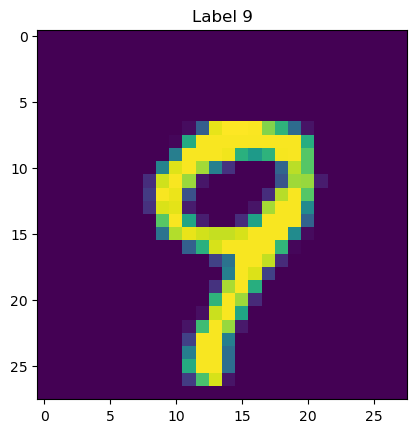

In [3]:
# Visualize an image from the dataset
for i, data in enumerate(train_loader):
    images, labels = data
    break
print('Shape of images from one batch : ', images.shape)
print('Shape of labels from one batch : ', labels.shape)

plt.imshow(images[0, 0])
plt.title('Label {}'.format(labels[0]))

## Define a convolutional neural network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)  # 7*7 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Set whether to readout activation
        self.readout = False

    def forward(self, x):
        # Max pooling over a (2, 2) window
        l1 = F.max_pool2d(F.relu(self.conv1(x)), 2)
        l2 = F.max_pool2d(F.relu(self.conv2(l1)), 2)
        l2_flat = torch.flatten(l2, start_dim=1)  # flatten tensor, while keeping batch dimension
        l3 = F.relu(self.fc1(l2_flat))
        l4 = F.relu(self.fc2(l3))
        y = self.fc3(l4)
        
        if self.readout:
            return {'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4, 'y': y}
        else:
            return y

## Training the network

The following code trains the above network on MNIST until it reaches 95% accuracy. It should take only ~500-1000 training steps.

In [5]:
import torch.optim as optim

# Instantiate the network and print information
net = Net()
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train for only one epoch
running_loss = 0
running_acc = 0
for i, data in enumerate(train_loader):
    image, label = data

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()    # Does the update

    # prediction
    prediction = torch.argmax(output, axis=-1)
    acc = torch.mean((label == prediction).float())

    running_loss += loss.item()
    running_acc += acc
    if i % 100 == 99:
        running_loss /= 100
        running_acc /= 100
        print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(
            i+1, running_loss, running_acc))
        if running_acc > 0.95:
            break
        running_loss, running_acc = 0, 0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Step 100, Loss 0.7950, Acc 0.742
Step 200, Loss 0.2833, Acc 0.918
Step 300, Loss 0.2628, Acc 0.917
Step 400, Loss 0.2397, Acc 0.933
Step 500, Loss 0.2582, Acc 0.926
Step 600, Loss 0.2354, Acc 0.941
Step 700, Loss 0.2109, Acc 0.938
Step 800, Loss 0.2260, Acc 0.936
Step 900, Loss 0.2390, Acc 0.939
Step 1000, Loss 0.1895, Acc 0.947
Step 1100, Loss 0.1968, Acc 0.950
Step 1200, Loss 0.1733, Acc 0.953


## Compute representation similarity

We will first compute the neural responses to a batch of images

In [6]:
for i, data in enumerate(test_loader):
    images, labels = data
    break

# Readout network activity
net.readout = True
activity = net(images)

n_images = len(labels)

ind = np.argsort(labels.numpy())
images = images.detach().numpy()[ind]
labels = labels.numpy()[ind]

similarity = dict()
for key, val in activity.items():
    new_val = val.detach().numpy()[ind]
    activity[key] = new_val
    new_val = new_val.reshape(n_images, -1)
    similarity[key] = np.corrcoef(new_val)

Here we plot the representational dissimilarity matrix for neural responses of different layers

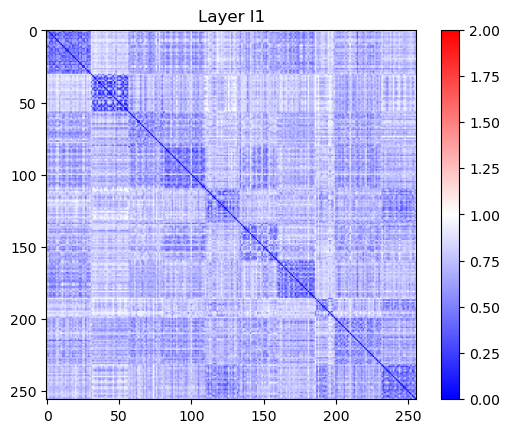

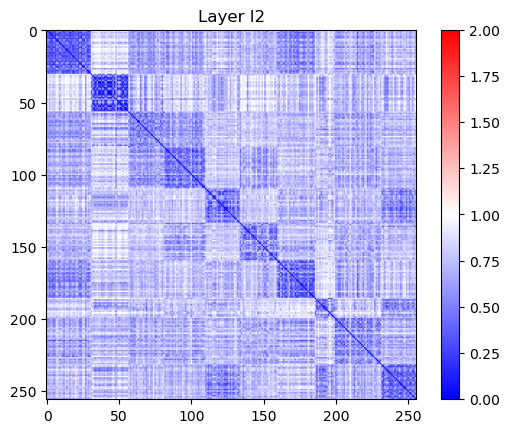

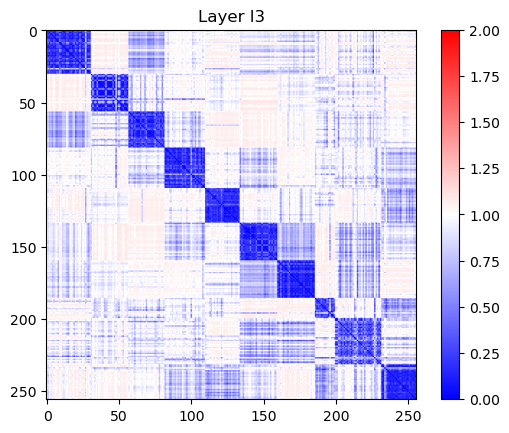

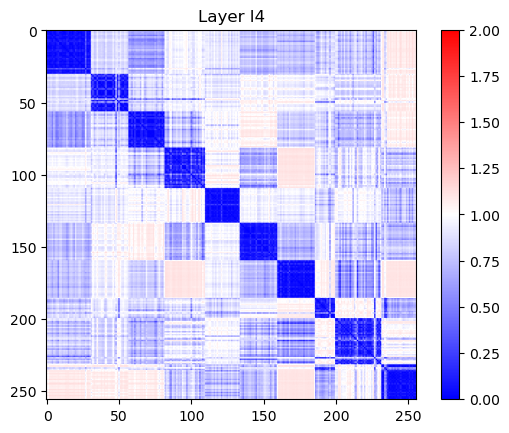

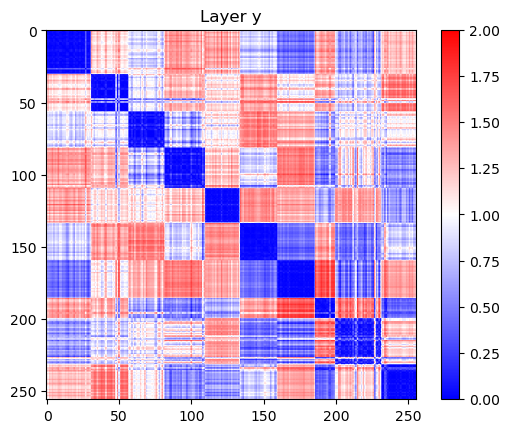

In [7]:
for layer, sim in similarity.items():
    plt.figure()
    plt.imshow(1 - sim, vmin=0, vmax=2, cmap='bwr')
    plt.colorbar()
    plt.title('Layer ' + layer)

## Search for preferred stimulus for a given neuron

We will optimize images (not weights) such as the activity of a chosen neuron is maximized

In [8]:
# Freeze for parameters in the network
for param in net.parameters():
    param.requires_grad = False
    

# Here syn_image is the variable to be optimized
# Initialized randomly for search in parallel
batch_size = 64
image_size = [batch_size] + list(images.shape[1:])
syn_image_init = np.random.rand(*image_size)
syn_image = torch.tensor(syn_image_init, requires_grad=True, dtype=torch.float32)

# Use Adam optimizer
optimizer = optim.Adam([syn_image], lr=0.01)

running_loss = 0
for i in range(1000):
    optimizer.zero_grad()   # zero the gradient buffers
    syn_image.data.clamp_(min=0.0, max=1.0)
    syn_image_transform = (syn_image - 0.1307) / 0.3081
    act = net(syn_image_transform)
    
    # Pick a neuron, and minimize its negative activity
    neuron = act['l4'][:, 1]
    if i == 0:
        neuron_init = neuron.detach().numpy()

    loss = -torch.mean(torch.square(neuron))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        running_loss /= 100
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

neuron = neuron.detach().numpy()
syn_image = syn_image.detach().numpy()

Step 100, Loss -44.2816
Step 200, Loss -93.3128
Step 300, Loss -104.6943
Step 400, Loss -109.8021
Step 500, Loss -112.2260
Step 600, Loss -113.4404
Step 700, Loss -114.2981
Step 800, Loss -114.8790
Step 900, Loss -115.3998
Step 1000, Loss -115.5577


Plot the neural activity driven by a batch of images before and after the optimization process. After optimization, many images can drive the unit strongly.

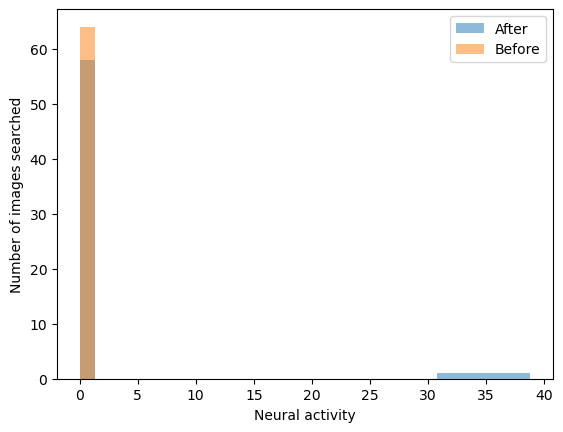

In [9]:
bins = np.linspace(0, np.max(neuron), 30)
plt.figure()
plt.hist(neuron, bins, label='After', alpha=0.5)
plt.hist(neuron_init, bins, label='Before', alpha=0.5)
plt.xlabel('Neural activity')
plt.ylabel('Number of images searched')
plt.legend()

Visualize the image that most strongly activates the chosen unit, before and after optimization.

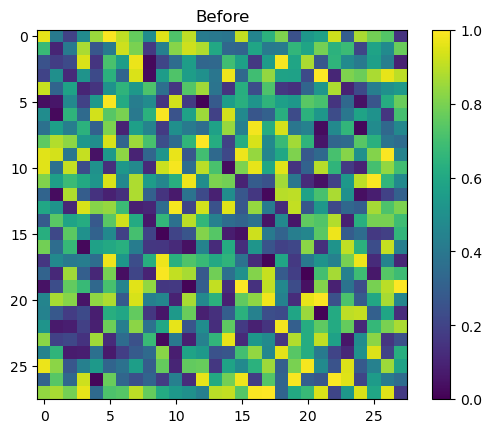

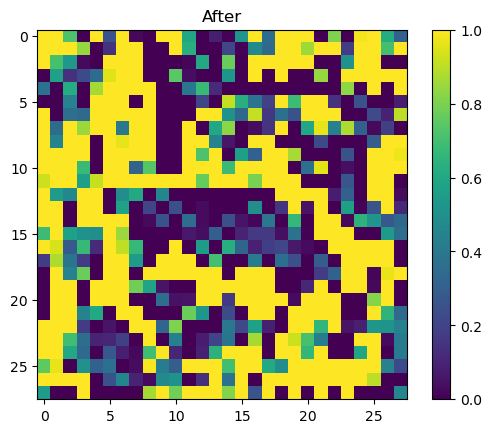

In [10]:
ind = np.argsort(neuron)
plt.figure()
plt.title('Before')
plt.imshow(syn_image_init[ind[-1], 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure()
plt.title('After')
plt.imshow(syn_image[ind[-1], 0], vmin=0, vmax=1)
plt.colorbar()

## Neural Feature Encoding and Decoding

Neural encoding function

In [ ]:
def neural_encoding_analysis(layer, activity):
    activation = activity[layer]
    neuron_index = 0  # Select the index of the neuron to analyze
    neuron_activations = activation[:, neuron_index]

    mean_activation = np.mean(neuron_activations)
    poisson_fit = poisson(mean_activation)

    plt.figure(figsize=(8, 6))
    plt.hist(neuron_activations, bins=20, density=True, alpha=0.6, label='Observed activations')
    x = np.arange(0, int(np.max(neuron_activations)) + 1)
    plt.plot(x, poisson_fit.pmf(x), 'o-', label='Poisson fit')

    # Set font size
    plt.xlabel('Neuron activation', fontsize=14)  # X-axis label font
    plt.ylabel('Probability density', fontsize=14)  # Y-axis label font
    plt.title(f'Poisson Fit for Neuron {neuron_index} in Layer {layer}', fontsize=16)  # Title font
    plt.xticks(fontsize=12)  # X-axis tick font
    plt.yticks(fontsize=12)  # Y-axis tick font
    plt.legend(fontsize=12)  # Legend font
    plt.grid(True)  # Add grid lines
    plt.show()

Neural decoding function

In [ ]:
def neural_decoding_analysis(layer, activity, labels):
    activation = activity[layer]
    features = activation.reshape(activation.shape[0], -1)  # Flatten the activation values
    labels = labels.numpy() if hasattr(labels, "numpy") else labels  # Ensure labels are numpy.ndarray

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    decoder = LogisticRegression(max_iter=1000)
    decoder.fit(X_train, y_train)

    y_pred = decoder.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Decoding accuracy using layer {layer}: {accuracy * 100:.2f}%')

Neural Feature Encoding and Decoding Analysis

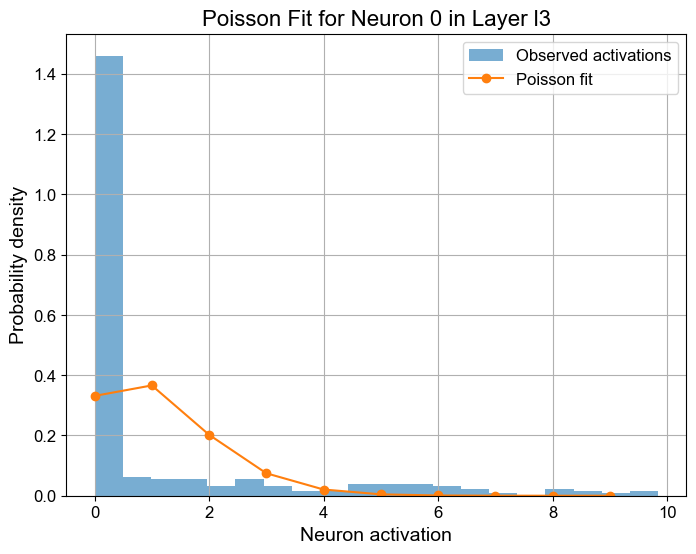

Decoding accuracy using layer l3: 94.23%


In [ ]:
neural_encoding_analysis('l3', activity)

neural_decoding_analysis('l3', activity, labels)

## Rotation Tuning Analysis of Neuronal Response

Generate rotated images

In [ ]:
def generate_rotated_images(image, angles):
    """
    Input:
    - image: 3D tensor (channels, height, width) or 2D tensor (height, width)
    - angles: List of rotation angles
    Output:
    - rotated_images: 4D tensor (batch_size, channels, height, width)
    """
    if len(image.shape) == 2:  # If the image is 2D
        image = image.unsqueeze(0)  # Add channel dimension, turning it into (1, height, width)
    
    rotated_images = []
    for angle in angles:
        rotated = TF.rotate(image, angle)  # Use torchvision.transforms.functional.rotate
        rotated_images.append(rotated)
    
    return torch.stack(rotated_images, dim=0)  # Stack into a batch

Compute the neuron response

In [ ]:
def tuning_curve_analysis(net, layer, neuron_index, base_image, angles):
    """
    Analyze the tuning curve of a neuron
    Input:
    - net: Neural network model
    - layer: Target layer name (e.g., 'l4')
    - neuron_index: Neuron index
    - base_image: Base image (channels, height, width)
    - angles: List of rotation angles
    Output:
    - angles: List of angles
    - responses: Corresponding neuron response values
    """
    # Initialize result
    responses = []

    # Generate a series of rotated images, ensuring the correct input dimensions
    rotated_images = generate_rotated_images(base_image, angles)

    # Ensure the model reads intermediate activations
    net.readout = True
    activity = net(rotated_images)  # Forward pass

    # Extract activations from the target layer
    activations = activity[layer]  # Ensure correct data from the target layer

    # Record the target neuron activation for each rotated image
    for i, angle in enumerate(angles):
        neuron_response = activations[i, neuron_index]
        responses.append(neuron_response)

    # Plot the tuning curve
    plt.figure(figsize=(8, 6))
    plt.plot(angles, responses, '-o')

    # Set font size
    plt.xlabel('Rotation angle (degrees)', fontsize=14)  # X-axis label font
    plt.ylabel('Neuron activation', fontsize=14)  # Y-axis label font
    plt.title(f'Tuning Curve of Neuron {neuron_index} in Layer {layer}', fontsize=16)  # Title font
    plt.xticks(fontsize=12)  # X-axis tick font
    plt.yticks(fontsize=12)  # Y-axis tick font
    plt.grid(True)  # Add grid lines
    plt.show()

    return angles, responses

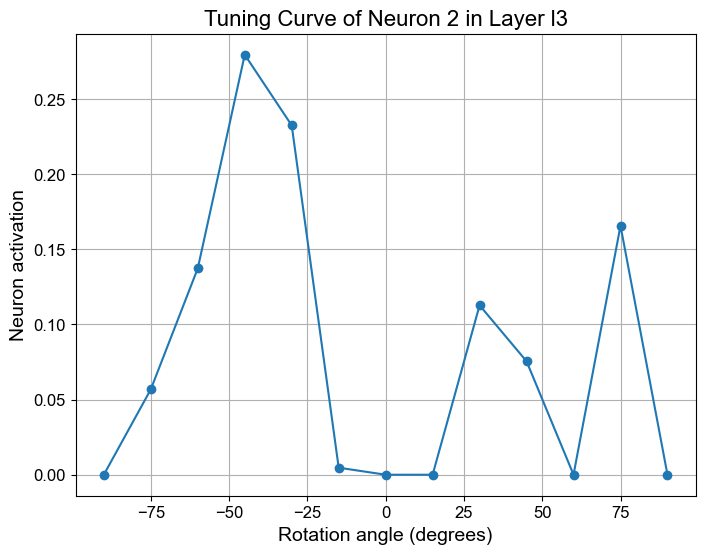

In [ ]:
layer = 'l3'
neuron_index = 2

# Ensure base_image is a 3D tensor
base_image = torch.tensor(syn_image[0, 0])  # Ensure the input is a 3D tensor (channels, height, width)

# Rotation angle range
angles = np.linspace(-90, 90, 13)  # From -90° to 90°, taking one angle every 15°

# Tuning curve analysis
angles, responses = tuning_curve_analysis(net, layer, neuron_index, base_image, angles)


## Signal Detection Analysis for Neural Discriminability

In [ ]:
def signal_detection_analysis(net, layer, neuron_index, test_loader, class1, class2):
    """
    Analyze the ability of the target neuron to distinguish between two classes of inputs and calculate the d-prime value.
    
    Input:
    - net: Neural network model
    - layer: Target layer name (e.g., 'l4')
    - neuron_index: Neuron index
    - test_loader: DataLoader for the test dataset
    - class1, class2: Labels of the two classes (e.g., 1 and 7)
    
    Output:
    - d_prime: d' value
    """
    # Initialize lists to store activation values
    activations_class1 = []
    activations_class2 = []

    # Set the model to read intermediate activations mode
    net.readout = True

    # Loop through the test dataset and record activations for both classes
    for images, labels in test_loader:
        images, labels = images.to('cpu'), labels.to('cpu')  # Ensure it runs on CPU
        activity = net(images)
        activations = activity[layer].detach().numpy()

        # Filter activations by class
        for i, label in enumerate(labels):
            if label == class1:
                activations_class1.append(activations[i, neuron_index])
            elif label == class2:
                activations_class2.append(activations[i, neuron_index])
    
    # Convert to NumPy arrays
    activations_class1 = np.array(activations_class1)
    activations_class2 = np.array(activations_class2)

    # Compute mean and standard deviation
    mu1, mu2 = activations_class1.mean(), activations_class2.mean()
    sigma1, sigma2 = activations_class1.std(), activations_class2.std()
    sigma = np.sqrt((sigma1**2 + sigma2**2) / 2)

    # Calculate d-prime value
    d_prime = (mu1 - mu2) / sigma

    # Plot activation value distributions
    plt.figure(figsize=(8, 6))
    plt.hist(activations_class1, bins=20, alpha=0.5, label=f'Class {class1}')
    plt.hist(activations_class2, bins=20, alpha=0.5, label=f'Class {class2}')
    plt.axvline(mu1, color='blue', linestyle='--', label=f'Class {class1} Mean')
    plt.axvline(mu2, color='orange', linestyle='--', label=f'Class {class2} Mean')

    # Set font size
    plt.xlabel('Neuron activation', fontsize=14)  # X-axis label font
    plt.ylabel('Frequency', fontsize=14)  # Y-axis label font
    plt.title(f'Signal Detection Analysis for Neuron {neuron_index} in Layer {layer}', fontsize=16)  # Title font
    plt.xticks(fontsize=12)  # X-axis tick font
    plt.yticks(fontsize=12)  # Y-axis tick font
    plt.legend(fontsize=12)  # Legend font
    plt.grid(True)  # Add grid lines
    plt.show()

    return d_p

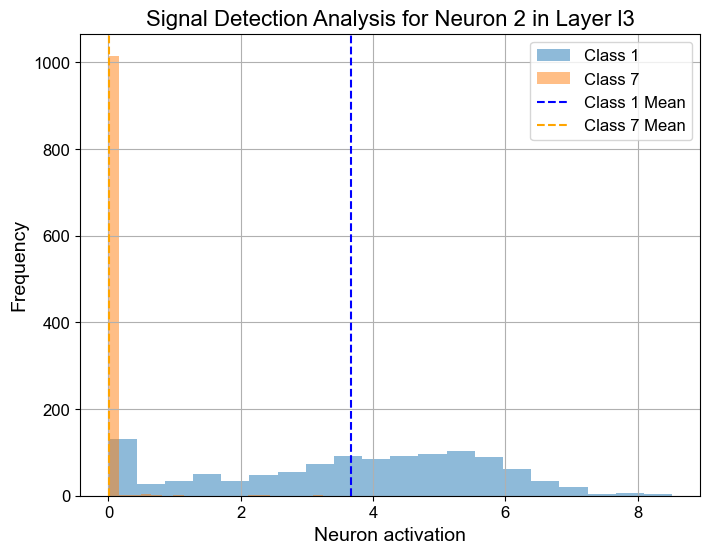

d-prime value for Neuron 2 in Layer l3: 2.52


In [ ]:
# Target layer and neuron index
layer = 'l3'
neuron_index = 2

# Specify classes
class1, class2 = 1, 7  # Compare class 1 and class 7

# Call signal detection analysis
d_prime = signal_detection_analysis(net, layer, neuron_index, test_loader, class1, class2)
print(f'd-prime value for Neuron {neuron_index} in Layer {layer}: {d_prime:.2f}')